In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, callbacks
import warnings
warnings.filterwarnings('ignore')

Downloading dataset

In [14]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [15]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

File ‘ml-100k.zip’ already there; not retrieving.

Archive:  ml-100k.zip


Configuring for visualization

In [16]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Core Component

In [17]:
class MovieRecommenderSystem:

    def __init__(self, n_factors=150, dropout_rate=0.3):
        self.n_factors = n_factors
        self.dropout_rate = dropout_rate
        self.model = None
        self.user_encoder = LabelEncoder()
        self.movie_encoder = LabelEncoder()
        self.refined_dataset = None
        self.min_rating = None
        self.max_rating = None
        self.n_users = None
        self.n_movies = None
        self.history = None

    def load_and_preprocess_data(self, data_path='ml-100k'):
        print("=" * 80)
        print("LOADING MOVIELENS DATASET")
        print("=" * 80)

        column_names_ratings = ['user id', 'movie id', 'rating', 'timestamp']
        ratings_df = pd.read_csv(
            f'{data_path}/u.data',
            sep='\t',
            header=None,
            names=column_names_ratings
        )
        print(f"Loaded {len(ratings_df):,} ratings")

        column_names_movies = [
            'movie id', 'movie title', 'release date', 'video release date',
            'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
            'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
            'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
            'Thriller', 'War', 'Western'
        ]
        movies_df = pd.read_csv(
            f'{data_path}/u.item',
            sep='|',
            header=None,
            names=column_names_movies,
            encoding='latin-1'
        )
        print(f"Loaded {len(movies_df):,} movies")

        movies_df = movies_df[['movie id', 'movie title']]

        merged_df = pd.merge(ratings_df, movies_df, on='movie id', how='inner')

        self.refined_dataset = merged_df.groupby(
            ['user id', 'movie title'],
            as_index=False
        ).agg({'rating': 'mean'})

        print(f"Created refined dataset with {len(self.refined_dataset):,} unique user-movie pairs")


        # Encode users and movies
        self.refined_dataset['user'] = self.user_encoder.fit_transform(
            self.refined_dataset['user id'].values
        )
        self.refined_dataset['movie'] = self.movie_encoder.fit_transform(
            self.refined_dataset['movie title'].values
        )

        self.n_users = self.refined_dataset['user'].nunique()
        self.n_movies = self.refined_dataset['movie'].nunique()
        self.min_rating = self.refined_dataset['rating'].min()
        self.max_rating = self.refined_dataset['rating'].max()

        print(f" Encoded {self.n_users} users and {self.n_movies} movies")
        print(f" Rating range: {self.min_rating} - {self.max_rating}")
        print("=" * 80)

        return self.refined_dataset

    def prepare_training_data(self, test_size=0.15, random_state=42):

        X = self.refined_dataset[['user', 'movie']].values
        y = self.refined_dataset['rating'].values.astype(np.float32)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

        # Separate user and movie inputs
        X_train_array = [X_train[:, 0], X_train[:, 1]]
        X_test_array = [X_test[:, 0], X_test[:, 1]]

        # Normalize ratings to [0, 1] range
        y_train_norm = (y_train - self.min_rating) / (self.max_rating - self.min_rating)
        y_test_norm = (y_test - self.min_rating) / (self.max_rating - self.min_rating)

        print(f"Training samples: {len(y_train):,}")
        print(f"Testing samples: {len(y_test):,}")

        return X_train_array, X_test_array, y_train_norm, y_test_norm

    def build_model(self, architecture='enhanced'):

        print("\n" + "=" * 80)
        print("BUILDING NEURAL NETWORK ARCHITECTURE")
        print("=" * 80)

        # User input and embedding
        user_input = layers.Input(shape=(1,), name='user_input')
        user_embedding = layers.Embedding(
            input_dim=self.n_users,
            output_dim=self.n_factors,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6),
            name='user_embedding'
        )(user_input)
        user_vec = layers.Reshape((self.n_factors,))(user_embedding)

        # Movie input and embedding
        movie_input = layers.Input(shape=(1,), name='movie_input')
        movie_embedding = layers.Embedding(
            input_dim=self.n_movies,
            output_dim=self.n_factors,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6),
            name='movie_embedding'
        )(movie_input)
        movie_vec = layers.Reshape((self.n_factors,))(movie_embedding)

        if architecture == 'enhanced':
            # Enhanced architecture with residual connections
            concat = layers.Concatenate()([user_vec, movie_vec])
            concat = layers.Dropout(self.dropout_rate)(concat)

            # First dense block
            x = layers.Dense(128, kernel_initializer='he_normal')(concat)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            x = layers.Dropout(self.dropout_rate)(x)

            # Second dense block
            x = layers.Dense(64, kernel_initializer='he_normal')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            x = layers.Dropout(self.dropout_rate)(x)

            # Third dense block
            x = layers.Dense(32, kernel_initializer='he_normal')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            x = layers.Dropout(self.dropout_rate / 2)(x)

            # Output layer (9 classes for ratings 1-5, discretized)
            output = layers.Dense(9, activation='softmax', name='output')(x)

        else:  # Original architecture
            concat = layers.Concatenate()([user_vec, movie_vec])
            x = layers.Dropout(0.05)(concat)
            x = layers.Dense(32, kernel_initializer='he_normal')(x)
            x = layers.Activation('relu')(x)
            x = layers.Dropout(0.05)(x)
            x = layers.Dense(16, kernel_initializer='he_normal')(x)
            x = layers.Activation('relu')(x)
            x = layers.Dropout(0.05)(x)
            output = layers.Dense(9, activation='softmax', name='output')(x)

        # Create model
        self.model = models.Model(
            inputs=[user_input, movie_input],
            outputs=output,
            name='MovieRecommender'
        )

        # Compile model
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
        )

        print(self.model.summary())
        print("=" * 80)

        return self.model

    def train_model(self, X_train, y_train, X_test, y_test, epochs=100, batch_size=128):

        print("\n" + "=" * 80)
        print("TRAINING MODEL")
        print("=" * 80)

        # Callbacks
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )

        early_stop = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        )

        # Train model
        self.history = self.model.fit(
            x=X_train,
            y=y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[reduce_lr, early_stop],
            shuffle=True
        )

        print("=" * 80)
        print("TRAINING COMPLETED")
        print("=" * 80)

        return self.history

    def plot_training_history(self):

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        axes[0].plot(self.history.history['loss'], label='Training Loss', linewidth=2)
        axes[0].plot(self.history.history['val_loss'], label='Validation Loss', linewidth=2)
        axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3)

        # Accuracy plot
        axes[1].plot(self.history.history['accuracy'], label='Training Accuracy', linewidth=2)
        axes[1].plot(self.history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        axes[1].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Accuracy', fontsize=12)
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def get_recommendations(self, user_id, n_recommendations=20, show_seen=True):

        print("\n" + "=" * 80)
        print(f"GENERATING RECOMMENDATIONS FOR USER {user_id}")
        print("=" * 80)

        # Encode user ID
        try:
            encoded_user_id = self.user_encoder.transform([user_id])[0]
        except ValueError:
            print(f"Error: User ID {user_id} not found in dataset!")
            return None

        # Get movies already seen by user
        seen_movies = list(
            self.refined_dataset[self.refined_dataset['user id'] == user_id]['movie']
        )

        if show_seen:
            seen_titles = list(
                self.refined_dataset[self.refined_dataset['user id'] == user_id]['movie title']
            )
            print(f"\n Movies already watched by User {user_id}: {len(seen_titles)}")
            print("-" * 80)
            for i, title in enumerate(seen_titles[:10], 1):
                print(f"  {i}. {title}")
            if len(seen_titles) > 10:
                print(f"  ... and {len(seen_titles) - 10} more")
            print()

        # Get unseen movies
        all_movies = list(range(self.n_movies))
        unseen_movies = [m for m in all_movies if m not in seen_movies]

        # Prepare model input
        user_array = np.array([encoded_user_id] * len(unseen_movies))
        movie_array = np.array(unseen_movies)

        # Predict ratings
        predictions = self.model.predict(
            [user_array, movie_array],
            verbose=0,
            batch_size=512
        )

        # Get maximum probability for each movie
        predicted_scores = np.max(predictions, axis=1)

        # Sort by predicted scores
        top_indices = np.argsort(predicted_scores)[::-1][:n_recommendations]
        recommended_movie_ids = [unseen_movies[i] for i in top_indices]
        recommended_scores = [predicted_scores[i] for i in top_indices]

        # Get movie titles
        recommended_titles = self.movie_encoder.inverse_transform(recommended_movie_ids)

        print("=" * 80)
        print(f" TOP {n_recommendations} MOVIE RECOMMENDATIONS")
        print("=" * 80)

        recommendations = []
        for i, (title, score) in enumerate(zip(recommended_titles, recommended_scores), 1):
            print(f"{i:2d}. {title:60s} (Score: {score:.4f})")
            recommendations.append({'rank': i, 'title': title, 'score': score})

        print("=" * 80)

        return pd.DataFrame(recommendations)

    def analyze_user_preferences(self, user_id):
        """Analyze user's movie preferences and rating patterns"""
        user_data = self.refined_dataset[self.refined_dataset['user id'] == user_id]

        if len(user_data) == 0:
            print(f"No data found for user {user_id}")
            return

        print("\n" + "=" * 80)
        print(f"USER {user_id} PROFILE ANALYSIS")
        print("=" * 80)

        print(f"\n Statistics:")
        print(f"  Total movies rated: {len(user_data)}")
        print(f"  Average rating: {user_data['rating'].mean():.2f}")
        print(f"  Median rating: {user_data['rating'].median():.2f}")
        print(f"  Rating std dev: {user_data['rating'].std():.2f}")

        # Rating distribution
        print(f"\n Rating Distribution:")
        rating_counts = user_data['rating'].value_counts().sort_index()
        for rating, count in rating_counts.items():
            bar = '█' * int(count / max(rating_counts) * 30)
            print(f"  {rating:.1f}: {bar} ({count})")

        # Top rated movies
        print(f"\n Top 5 Highest Rated Movies:")
        top_movies = user_data.nlargest(5, 'rating')[['movie title', 'rating']]
        for idx, (_, row) in enumerate(top_movies.iterrows(), 1):
            print(f"  {idx}. {row['movie title']} - Rating: {row['rating']:.1f}")

        print("=" * 80)

    def save_model(self, filepath='movie_recommender_model.keras'):
        """Save trained model"""
        self.model.save(filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath='movie_recommender_model.keras'):
        """Load pre-trained model"""
        self.model = keras.models.load_model(filepath)
        print(f"Model loaded from {filepath}")


Main Execution

In [18]:
def main():
    # Initialize recommender system
    recommender = MovieRecommenderSystem(n_factors=150, dropout_rate=0.3)

    # Load and preprocess data
    dataset = recommender.load_and_preprocess_data()

    # Prepare training data
    X_train, X_test, y_train, y_test = recommender.prepare_training_data(
        test_size=0.15,
        random_state=42
    )

    # Build model with enhanced architecture
    recommender.build_model(architecture='enhanced')

    # Train model
    history = recommender.train_model(
        X_train, y_train,
        X_test, y_test,
        epochs=100,
        batch_size=128
    )

    # Visualize training
    recommender.plot_training_history()

    # Save model
    recommender.save_model('movie_recommender.keras')

    # Interactive recommendation system
    print("WELCOME TO MOVIE RECOMMENDATION SYSTEM")

    while True:
        try:
            print("\n" + "=" * 80)
            user_id_input = input("Enter User ID (1-943) or 'q' to quit: ").strip()

            if user_id_input.lower() == 'q':
                print("\n Thank you for using the Movie Recommendation System! (Developed by Tanish)")
                print("=" * 80)
                break

            user_id = int(user_id_input)

            # Validate user ID
            if user_id not in recommender.refined_dataset['user id'].values:
                print(f"\n Error: User ID {user_id} not found in dataset!")
                print(f"   Valid range: 1-943")
                continue

            # Ask for number of recommendations
            n_recs_input = input("Enter number of recommendations (default 20): ").strip()
            n_recommendations = int(n_recs_input) if n_recs_input else 20

            # Analyze user preferences
            recommender.analyze_user_preferences(user_id)

            # Get recommendations
            recommendations = recommender.get_recommendations(
                user_id=user_id,
                n_recommendations=n_recommendations,
                show_seen=True
            )

            # Ask if user wants to continue
            print("\n" + "-" * 80)
            continue_input = input("Try another user? (y/n): ").strip().lower()
            if continue_input != 'y':
                print("\n Thank you for using the Movie Recommendation System! (Developed by Tanish)")
                print("=" * 80)
                break

        except ValueError:
            print("\n Invalid input! Please enter a valid number.")
        except KeyboardInterrupt:
            print("\n\n👋 Goodbye!")
            break
        except Exception as e:
            print(f"\n An error occurred: {str(e)}")

    return recommender

LOADING MOVIELENS DATASET
Loaded 100,000 ratings
Loaded 1,682 movies
Created refined dataset with 99,693 unique user-movie pairs
 Encoded 943 users and 1664 movies
 Rating range: 1.0 - 5.0
Training samples: 84,739
Testing samples: 14,954

BUILDING NEURAL NETWORK ARCHITECTURE


Model: "MovieRecommender"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 150)    │    141,450 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 150)    │    249,600 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 150)       │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 150)       │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 300)       │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 300)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     38,528 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 32)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 441,107 (1.68 MB)

 Trainable params: 440,659 (1.68 MB)

 Non-trainable params: 448 (1.75 KB)

None

TRAINING MODEL
Epoch 1/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.0692 - loss: 0.9938 - val_accuracy: 0.1091 - val_loss: 0.4528 - learning_rate: 0.0010
Epoch 2/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.1009 - loss: 0.4487 - val_accuracy: 0.1279 - val_loss: 0.4318 - learning_rate: 0.0010
Epoch 3/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.1093 - loss: 0.4233 - val_accuracy: 0.1158 - val_loss: 0.4267 - learning_rate: 0.0010
Epoch 4/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.1111 - loss: 0.4134 - val_accuracy: 0.1194 - val_loss: 0.4259 - learning_rate: 0.0010
Epoch 5/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.1147 - loss: 0.4013 - val_accuracy: 0.1303 - val_loss: 0.4263 - learning_rate: 0.0010
Epoch 6/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.1205 - loss: 0.3991 - val_accuracy: 0.1266 - val_loss: 0.4276 - learning_rate: 0.0010
Epoch 7/100
663/663 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step

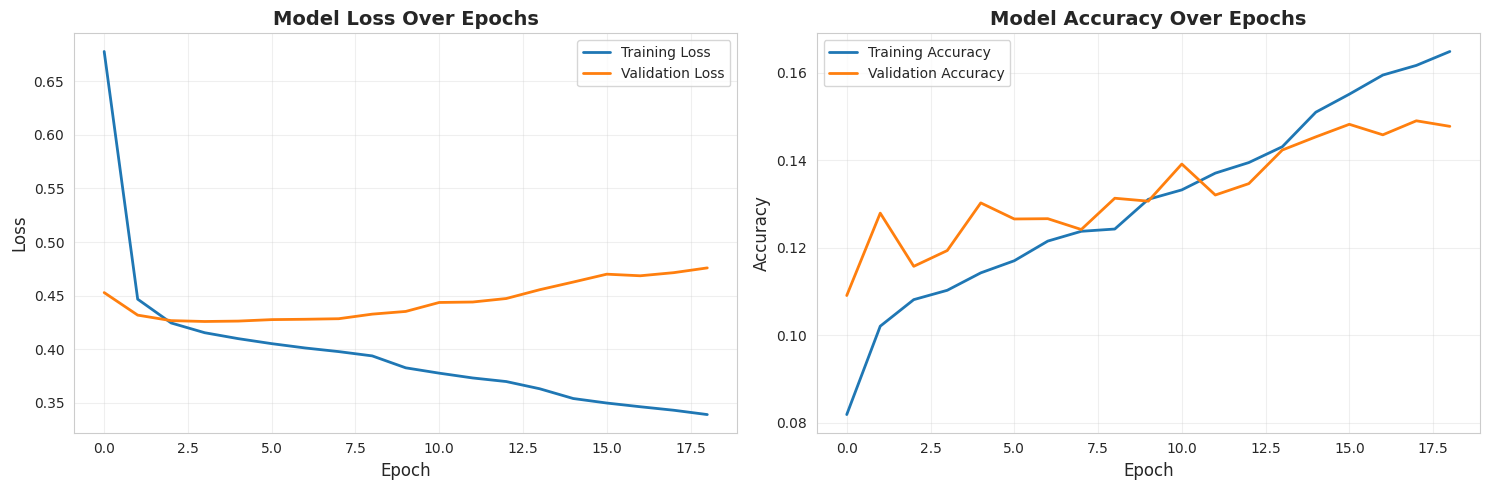

Model saved to movie_recommender.keras
WELCOME TO MOVIE RECOMMENDATION SYSTEM

Enter User ID (1-943) or 'q' to quit: 344
Enter number of recommendations (default 20): 

USER 344 PROFILE ANALYSIS

 Statistics:
  Total movies rated: 188
  Average rating: 3.67
  Median rating: 4.00
  Rating std dev: 1.03

 Rating Distribution:
  1.0: ██ (5)
  2.0: ████████ (19)
  3.0: ████████████████████████ (53)
  3.5:  (1)
  4.0: ██████████████████████████████ (66)
  5.0: ████████████████████ (44)

 Top 5 Highest Rated Movies:
  1. Alien (1979) - Rating: 5.0
  2. Aliens (1986) - Rating: 5.0
  3. Amadeus (1984) - Rating: 5.0
  4. Apt Pupil (1998) - Rating: 5.0
  5. Babe (1995) - Rating: 5.0

GENERATING RECOMMENDATIONS FOR USER 344

 Movies already watched by User 344: 188
--------------------------------------------------------------------------------
  1. Absolute Power (1997)
  2. Addicted to Love (1997)
  3. Aladdin (1992)
  4. Alien (1979)
  5. Aliens (1986)
  6. Amadeus (1984)
  7. Antonia's Line (

In [19]:
if __name__ == "__main__":
    # Download dataset first (run in terminal):
    # wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
    # unzip -n ml-100k.zip

    recommender = main()